## EDA documento .JSON

Luis Angel Garcia (2230177)

## Librerias

In [1]:
import pandas as pd
import logging
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import pandas as pd
import ast 
from IPython.display import display
from sklearn.preprocessing import StandardScaler, LabelEncoder

sys.path.append("../config_documents")

## Configuracion del login

In [2]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

## Cargar archivo

In [3]:
data = []
with jsonlines.open("../source/MLA_100k.jsonlines") as reader:
    for obj in reader:
        data.append(obj)
df = pd.DataFrame(data)

df.to_csv("../source/productos.csv", index=False)

df = pd.read_csv("../source/productos.csv")


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   seller_address                    100000 non-null  object 
 1   warranty                          39103 non-null   object 
 2   sub_status                        100000 non-null  object 
 3   condition                         100000 non-null  object 
 4   seller_contact                    2219 non-null    object 
 5   deal_ids                          100000 non-null  object 
 6   base_price                        100000 non-null  float64
 7   shipping                          100000 non-null  object 
 8   non_mercado_pago_payment_methods  100000 non-null  object 
 9   seller_id                         100000 non-null  int64  
 10  variations                        100000 non-null  object 
 11  location                          100000 non-null  ob

None

In [5]:
columnas_analizadas = [
    'seller_address', 'shipping', 'geolocation',
    'non_mercado_pago_payment_methods', 'pictures',
    'attributes', 'descriptions'
]

for col in columnas_analizadas:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else None)


df['latitude'] = df['seller_address'].apply(lambda x: x.get('latitude') if x else None)
df['longitude'] = df['seller_address'].apply(lambda x: x.get('longitude') if x else None)
df['country'] = df['seller_address'].apply(lambda x: x.get('country', {}).get('name') if x else None)
df['state'] = df['seller_address'].apply(lambda x: x.get('state', {}).get('name') if x else None)
df['city'] = df['seller_address'].apply(lambda x: x.get('city', {}).get('name') if x else None)
df['neighborhood'] = df['seller_address'].apply(lambda x: x.get('search_location', {}).get('neighborhood', {}).get('name') if x else None)

df['free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping') if x else None)
df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode') if x else None)
df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up') if x else None)

df['geo_lat'] = df['geolocation'].apply(lambda x: x.get('latitude') if x else None)
df['geo_lon'] = df['geolocation'].apply(lambda x: x.get('longitude') if x else None)

df['num_pictures'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['num_non_mp_methods'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['title_length'] = df['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)

df['price_diff'] = df['price'] - df['base_price']

columnas_finales = [
    'id', 'title', 'condition', 'price', 'base_price', 'price_diff',
    'sold_quantity', 'available_quantity', 'accepts_mercadopago',
    'free_shipping', 'shipping_mode', 'local_pick_up',
    'latitude', 'longitude', 'country', 'state', 'city', 'neighborhood',
    'num_pictures', 'num_non_mp_methods', 'title_length'
]

df_final = df[columnas_finales].copy()


df_final.to_csv("../source/products_dataset.csv", index=False)

## Analisis basico

In [6]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_rows', None)

display('Primeras filas del dataset:\n',df_final.head())
print(df.dtypes)
print(df['condition'].unique())
print(df['shipping_mode'].unique())
print(df.isnull().sum())

'Primeras filas del dataset:\n'

,id,title,condition,price,base_price,price_diff,sold_quantity,available_quantity,accepts_mercadopago,free_shipping,shipping_mode,local_pick_up,latitude,longitude,country,state,city,neighborhood,num_pictures,num_non_mp_methods,title_length
0,MLA578052519,Auriculares Samsung Originales Manos Libres Ca...,new,80.0,80.0,0.0,0,1,True,False,not_specified,True,-34.62807,-58.398671,Argentina,Capital Federal,San Cristóbal,San Cristóbal,2,3,60
1,MLA581565358,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,used,2650.0,2650.0,0.0,0,1,True,False,me2,True,-34.593552,-58.505917,Argentina,Capital Federal,Buenos Aires,Villa Devoto,6,2,57
2,MLA578780872,"Antigua Revista Billiken, N° 1826, Año 1954",used,60.0,60.0,0.0,0,1,True,False,me2,True,-34.623391,-58.414395,Argentina,Capital Federal,Boedo,Boedo,1,3,43
3,MLA581877385,Alarma Guardtex Gx412 Seguridad Para El Automo...,new,580.0,580.0,0.0,0,1,True,False,me2,True,-34.628189,-58.492921,Argentina,Capital Federal,Floresta,Floresta,2,3,52
4,MLA576112692,Serenata - Jennifer Blake,used,30.0,30.0,0.0,0,1,True,False,not_specified,True,-34.634655,-58.549504,Argentina,Buenos Aires,Tres de febrero,,2,3,25


seller_address                       object
warranty                             object
sub_status                           object
condition                            object
seller_contact                       object
deal_ids                             object
base_price                          float64
shipping                             object
non_mercado_pago_payment_methods     object
seller_id                             int64
variations                           object
location                             object
site_id                              object
listing_type_id                      object
price                               float64
attributes                           object
buying_mode                          object
tags                                 object
listing_source                      float64
parent_item_id                       object
coverage_areas                       object
category_id                          object
descriptions                    

## Graficas

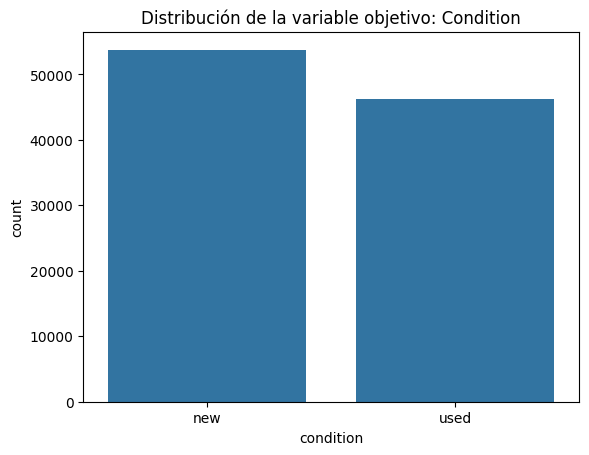

In [7]:
sns.countplot(x='condition', data=df)
plt.title('Distribución de la variable objetivo: Condition')
plt.show()

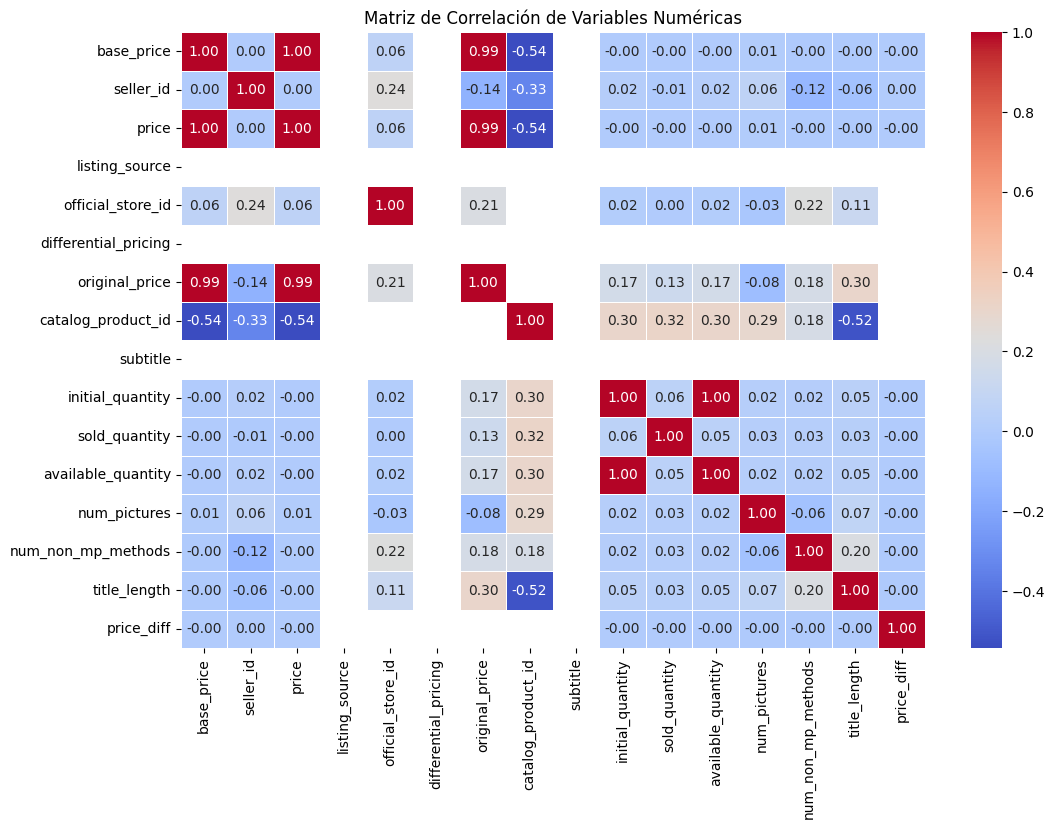

In [8]:
numerical_columns = df.select_dtypes(include=[float, int]).columns 
correlation_matrix = df[numerical_columns].corr()  

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

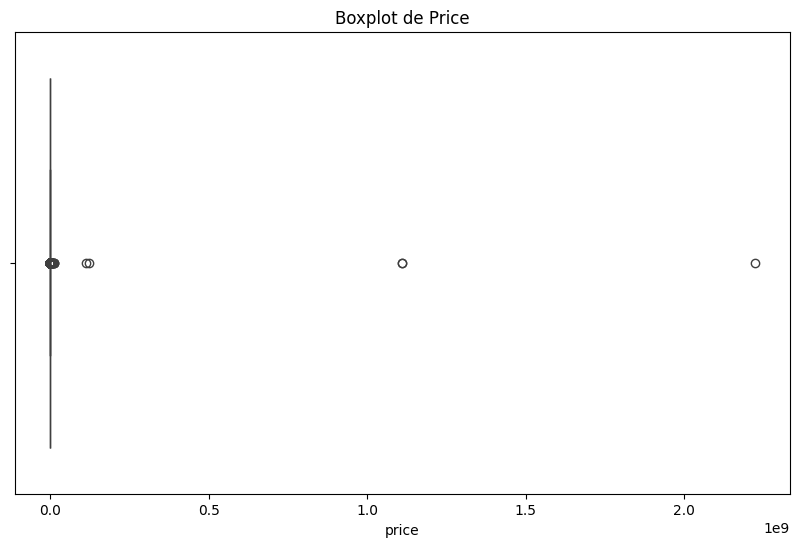

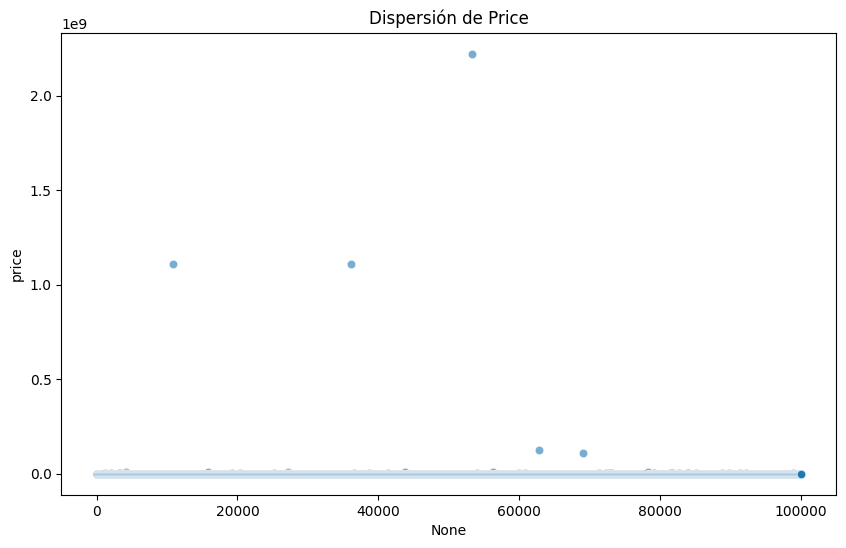

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot de Price')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['price'], alpha=0.6)
plt.title('Dispersión de Price')
plt.show()

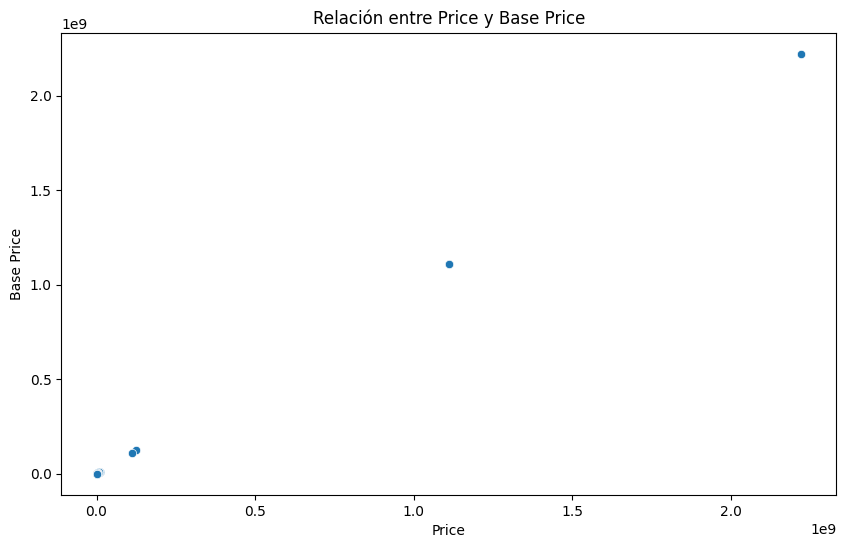

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['price'], y=df['base_price'])
plt.title('Relación entre Price y Base Price')
plt.xlabel('Price')
plt.ylabel('Base Price')
plt.show()

## Limpieza y transformacion

In [11]:
def clean_columns(df_final):
    columns_to_remove = ['id', 'title', 'local_pick_up', 'latitude', 'longitude']  
    df_cleaned = df_final.drop(columns=columns_to_remove, errors='ignore')  
    return df_cleaned

def encode_condition(df_cleaned):
    if df_cleaned['condition'].dtype != 'object':  
        df_cleaned['condition'] = df_cleaned['condition'].map({1.0: 'new', 0.0: 'used'})
    
    le = LabelEncoder()
    df_cleaned['condition'] = le.fit_transform(df_cleaned['condition'])
    
    df_cleaned['condition'] = df_cleaned['condition'].astype('int')
    
    print(f"Valores únicos en 'condition' después de la codificación: {df_cleaned['condition'].unique()}")
    print(f"Tipo de 'condition' después de la conversión: {df_cleaned['condition'].dtype}")
    
    return df_cleaned

def encode_categorical_columns(df_cleaned):
    categorical_columns = ['shipping_mode', 'accepts_mercadopago', 'free_shipping', 'country', 'state', 'city', 'neighborhood']
    
    for col in categorical_columns:
        df_cleaned[col] = df_cleaned[col].astype('category').cat.codes  

    return df_cleaned

def scale_features(df_cleaned, numerical_columns):
    scaler = StandardScaler()
    df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])
    return df_cleaned

def preprocess_data(df_final):
    df_cleaned = clean_columns(df_final)
    
    df_cleaned = encode_condition(df_cleaned)
    
    df_cleaned = encode_categorical_columns(df_cleaned)
    
    numerical_columns = df_cleaned.select_dtypes(include=np.number).columns

    df_cleaned = scale_features(df_cleaned, numerical_columns)
    
    df_cleaned['condition'] = df_cleaned['condition'].astype(int)

    X = df_cleaned.drop(columns=['condition'])  
    y = df_cleaned['condition']  
    
    df_cleaned.to_csv('../source/dataset_limpio.csv', index=False)

    print(f"Tipo de 'condition' después de guardar como CSV: {df_cleaned['condition'].dtype}")
    
    return X, y



X, y = preprocess_data(df_final)




Valores únicos en 'condition' después de la codificación: [0 1]
Tipo de 'condition' después de la conversión: int64
Tipo de 'condition' después de guardar como CSV: int64
